# Multimodal Calssification on Rakuten France Dataset

# Text Processing with FlauBERT Model
 



In [1]:
ls 

drive/  sample_data/


In [2]:
!mkdir Rakuten

In [3]:
cd '/content/Rakuten'

/content/Rakuten


In [4]:
!mkdir data 

In [5]:
pwd

'/content/Rakuten'

In [6]:
mkdir models

In [7]:
# cd '../'

In [8]:
# !cp '/content/drive/My Drive/Rakuten/data/NewTest.csv' data 
!cp '/content/drive/My Drive/Rakuten/data/NewTraining.csv' data 
!cp '/content/drive/My Drive/Rakuten/data/catalog_english_taxonomy.tsv' data 
!cp '/content/drive/My Drive/Rakuten/data/Y_train.tsv' data 

In [9]:
# cp '/content/drive/My Drive/Rakuten/models/FlauBERT_best_model_split_title.pt' models

# 1. Setup


# 1.1 Using Colab GPU for Training
Since we’ll be training a large neural network it’s best to take advantage of the free GPUs and TPUs that Google offers (in this case we’ll attach a GPU), otherwise training will take a very long time.

A GPU can be added by going to the menu and selecting:

Edit 🡒 Notebook Settings 🡒 Hardware accelerator 🡒 (GPU)

In [10]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


# 1.2. Installing the Hugging Face Library

Install the transformers package from Hugging Face which will give us a pytorch interface for working with BERT. This library contains interfaces for other pretrained language models.

We’ve selected the pytorch interface because it strikes a nice balance between the high-level APIs (which are easy to use but don’t provide insight into how things work) and tensorflow code (which contains lots of details but often sidetracks us into lessons about tensorflow, when the purpose here is BERT!).

At the moment, the Hugging Face library seems to be the most widely accepted and powerful pytorch interface for working with BERT. In addition to supporting a variety of different pre-trained transformer models, the library also includes pre-built modifications of these models suited to your specific task.
E.g "BertForSequenceClassification" that we will be using.

In [11]:
!pip install transformers
!pip install sentencepiece


     |████████████████████████████████| 2.1MB 4.2MB/s 
     |████████████████████████████████| 3.3MB 50.8MB/s 
     |████████████████████████████████| 901kB 51.1MB/s 
     |████████████████████████████████| 1.2MB 4.1MB/s 


# 2.  Dataset Loading and Preprocessing

In [12]:
import os
import pandas as pd
from tqdm._tqdm_notebook import tqdm_notebook
from google.colab import drive
tqdm_notebook.pandas(desc="Progress")
import torch
import torch.nn as nn
import numpy as np
from sklearn.model_selection import train_test_split
import torch.utils.data as data_utils

import html as ihtml
from bs4 import BeautifulSoup


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


# 2.1 Dataset Loading

In [13]:
text_data_path = '/content/Rakuten/data'
#image_data_path = '/content/Rakuten/image' 

In [14]:
class SigirPreprocess():

  def __init__(self, text_data_path):
    
        self.text_data_path = text_data_path
        self.train = None # Merged X_train and Y_train
        self.dict_code_to_id = {}
        self.dict_id_to_code = {}
        self.list_tags = {} #unique type code
        self.sentences = []
        self.labels = []
        self.text_col = None
        self.X_test = None

  def prepare_data(self):
        
        #loading the Merged, preprocessed text data and test data
        train = pd.read_csv(self.text_data_path+"/NewTraining.csv")
        # new_train =  train[train['Description'] != " "]
        # new_train = new_train[new_train['Description'].notna()]
        self.train = train

        
  def get_sentences(self, text_col, remove_null_rows=True):

       #get values of a specific column
        self.text_col = text_col        

        new_train = self.train.copy()  
        self.sentences = new_train[text_col].values
        self.labels = new_train['labels'].values


  # def prepare_test(self, text_col):
    
  #       X_test = pd.read_csv(self.text_data_path + "/NewTest.csv")
  #       self.X_test = X_test
  #       X_test['title_desc'] = X_test['Title'] + " " + X_test['Description']
  #       self.test_sentences = X_test[text_col].values
  #       return self.test_sentences
        

In [15]:
#Load train and test data (test for specific column)

text_col = 'Title'

max_len = 256

num_classes = 27

Preprocess = SigirPreprocess(text_data_path)
Preprocess.prepare_data()
train = Preprocess.train
print("Trian:  ", len(Preprocess.train))


Preprocess.get_sentences(text_col)
print("Labels: ", len(Preprocess.labels))

# X_test = Preprocess.prepare_test(text_col)
# print("Test:   ", len(Preprocess.X_test))

Trian:   55025
Labels:  55025


In [16]:
Preprocess = SigirPreprocess(text_data_path)
Preprocess.prepare_data()

print("Numner of records:  ",len(Preprocess.train))
print("Numner of corresponding Labels:  ",len(Preprocess.labels))


Numner of records:   55025
Numner of corresponding Labels:   0


# 2.2 Drop Records With No Description

In [17]:

new_train =  Preprocess.train[Preprocess.train['Description'] != " "]
Preprocess.train = new_train
Preprocess.labels = new_train['labels'].values

print("Numner of records without Null Description:  ",len(Preprocess.train))
print("Numner of corresponding Labels:  ",len(Preprocess.labels))

Numner of records without Null Description:   55025
Numner of corresponding Labels:   55025


In [18]:
len(Preprocess.train)

55025

In [19]:
Preprocess.train


,Unnamed: 0,Unnamed: 0.1,Integer_id,Title,Description,Image_id,Product_id,Prdtypecode,labels,product,title_len,desc_len,title_desc_len,title_desc
0,0,2,2,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,PILOT STYLE Touch Pen de marque Speedlink est ...,938777978,201115110,50,2,Entertainment,12,109,121,Grand Stylet Ergonomique Bleu Gamepad Nintendo...
1,1,4,4,La Guerre Des Tuques,Luc a des idées de grandeur. Il veut organiser...,1077757786,278535884,2705,4,Books,4,34,38,La Guerre Des Tuques Luc a des id&eacute;es de...
2,2,7,7,Conquérant Sept Cahier Couverture Polypro 240 ...,CONQUERANT CLASSIQUE Cahier 240 x 320 mm seyès...,999581347,344240059,2522,5,Books,14,18,32,Conquérant Sept Cahier Couverture Polypro 240 ...
3,3,9,9,Tente Pliante V3s5-Pro Pvc Blanc - 3 X 4m50 - ...,Tente pliante V3S5 Pro PVC 500 gr/m² - 3 x 4m5...,1245644185,3793572222,2582,6,Household,19,293,312,Tente Pliante V3s5-Pro Pvc Blanc - 3 X 4m50 - ...
4,4,10,10,Eames Inspired Sxw Chair - Pink - Black,The timeless DSW seat can now be paired with m...,1111840281,1915836983,1560,7,Household,8,94,102,Eames Inspired Sxw Chair - Pink - Black The ti...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55020,55111,84908,84908,Dimmerable Usb Led Lampe De Bureau Réglable Ch...,Nom de la marque:oobestAmpoules incluses:OuiCe...,1313620762,4198481300,2060,17,Household,18,37,55,Dimmerable Usb Led Lampe De Bureau Réglable Ch...
55021,55112,84909,84909,espa - kit complet de nage à contre courant 39...,espa espa - kit complet de nage à contre coura...,1043841028,853455937,2583,12,Household,17,173,190,espa - kit complet de nage à contre courant 39...
55022,55113,84910,84910,Vêtements Pour Animaux Mode Style Chiens Rayé ...,le t - shirt rayé mode chiens petits chiots v...,1158527239,2699568414,2220,22,Household,12,168,180,Vêtements Pour Animaux Mode Style Chiens Rayé ...
55023,55114,84912,84912,Kit piscine acier NEVADA déco pierre Ø 3.50m x...,Description complète :Kit piscine hors-sol Toi...,1188462883,3065095706,2583,12,Household,10,190,200,Kit piscine acier NEVADA déco pierre Ø 3.50m x...


# 2.3. Stripping Records Description

Remove HTML tags from the Desciption field using the BeautifulSoap library.

In [20]:
# from bs4 import BeautifulSoup
# Preprocess.train['Description'] = [BeautifulSoup(text).get_text() for text in  Preprocess.train['Description'] ]
# Preprocess.train['title_desc'] = [BeautifulSoup(text).get_text() for text in  Preprocess.train['title_desc'] ]
# Preprocess.train['Title'] = [BeautifulSoup(text).get_text() for text in  Preprocess.train['title_desc'] ]

In [21]:
print(len(Preprocess.train))

55025


In [22]:
Preprocess.train

,Unnamed: 0,Unnamed: 0.1,Integer_id,Title,Description,Image_id,Product_id,Prdtypecode,labels,product,title_len,desc_len,title_desc_len,title_desc
0,0,2,2,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,PILOT STYLE Touch Pen de marque Speedlink est ...,938777978,201115110,50,2,Entertainment,12,109,121,Grand Stylet Ergonomique Bleu Gamepad Nintendo...
1,1,4,4,La Guerre Des Tuques,Luc a des idées de grandeur. Il veut organiser...,1077757786,278535884,2705,4,Books,4,34,38,La Guerre Des Tuques Luc a des id&eacute;es de...
2,2,7,7,Conquérant Sept Cahier Couverture Polypro 240 ...,CONQUERANT CLASSIQUE Cahier 240 x 320 mm seyès...,999581347,344240059,2522,5,Books,14,18,32,Conquérant Sept Cahier Couverture Polypro 240 ...
3,3,9,9,Tente Pliante V3s5-Pro Pvc Blanc - 3 X 4m50 - ...,Tente pliante V3S5 Pro PVC 500 gr/m² - 3 x 4m5...,1245644185,3793572222,2582,6,Household,19,293,312,Tente Pliante V3s5-Pro Pvc Blanc - 3 X 4m50 - ...
4,4,10,10,Eames Inspired Sxw Chair - Pink - Black,The timeless DSW seat can now be paired with m...,1111840281,1915836983,1560,7,Household,8,94,102,Eames Inspired Sxw Chair - Pink - Black The ti...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55020,55111,84908,84908,Dimmerable Usb Led Lampe De Bureau Réglable Ch...,Nom de la marque:oobestAmpoules incluses:OuiCe...,1313620762,4198481300,2060,17,Household,18,37,55,Dimmerable Usb Led Lampe De Bureau Réglable Ch...
55021,55112,84909,84909,espa - kit complet de nage à contre courant 39...,espa espa - kit complet de nage à contre coura...,1043841028,853455937,2583,12,Household,17,173,190,espa - kit complet de nage à contre courant 39...
55022,55113,84910,84910,Vêtements Pour Animaux Mode Style Chiens Rayé ...,le t - shirt rayé mode chiens petits chiots v...,1158527239,2699568414,2220,22,Household,12,168,180,Vêtements Pour Animaux Mode Style Chiens Rayé ...
55023,55114,84912,84912,Kit piscine acier NEVADA déco pierre Ø 3.50m x...,Description complète :Kit piscine hors-sol Toi...,1188462883,3065095706,2583,12,Household,10,190,200,Kit piscine acier NEVADA déco pierre Ø 3.50m x...


In [23]:
text_col = 'Title'
max_len = 256

Preprocess.get_sentences(text_col,True)
sentences = Preprocess.sentences
labels = Preprocess.labels

In [24]:
sentences

array(['Grand Stylet Ergonomique Bleu Gamepad Nintendo Wii U - Speedlink Pilot Style',
       'La Guerre Des Tuques',
       'Conquérant Sept Cahier Couverture Polypro 240 X 320 Mm 96 Pages 90g Seyès Incolore',
       ...,
       'Vêtements Pour Animaux Mode Style Chiens Rayé T-Shirt Costume Petit Chiot Rouge',
       'Kit piscine acier NEVADA déco pierre Ø 3.50m x 0.90m',
       'Table Basse Bois De Récupération Massif Base Blanche 60x60x33cm'],
      dtype=object)

In [25]:
print(len(Preprocess.train))

55025


In [26]:
# Preprocess.train.to_csv('MyTraining.csv')

# 3. Tokenization & Input Formatting
Transform our dataset into the format that BERT can be trained on.

# 3.1. BERT Tokenizer

To feed our text to BERT, it must be split into tokens, and then these tokens must be mapped to their index in the tokenizer vocabulary.

The tokenization must be performed by the tokenizer included within BERT

In [27]:
from transformers import XLMForSequenceClassification
from transformers import FlaubertModel, FlaubertTokenizer,FlaubertForSequenceClassification,AdamW, FlaubertConfig 
from torch.nn import Dropout,Conv1d, Linear
from transformers.modeling_utils import SequenceSummary



modelname = 'flaubert/flaubert_base_cased'
tokenizer = FlaubertTokenizer.from_pretrained(modelname, do_lowercase=False)

# 3.2. Required Formatting
We are required to give it a number of pieces of information

We need to:

1.   Add special tokens to the start and end of each sentence.
2.   Pad & truncate all sentences to a single constant length.
3. Explicitly differentiate real tokens from padding tokens with the “attention mask”.




# 3.3. Tokenize Dataset

We will use "encode_plus":

returns a dictionary containing the encoded sequence or sequence pair and additional information:
the mask for sequence classification and the overflowing elements if a max_length is specified.

In [28]:
#function to prepare input for model training
def prep_input(sentences,labels, max_len):
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in sentences: 
        # `encode_plus` will:
        #   (1) Tokenize the sentence.
        #   (2) Prepend the `[CLS]` token to the start.
        #   (3) Append the `[SEP]` token to the end.
        #   (4) Map tokens to their IDs.
        #   (5) Pad or truncate the sentence to `max_length`
        #   (6) Create attention masks for [PAD] tokens.
        encoded_dict = tokenizer.encode_plus(
                            sent,                      # Sentence to encode.
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            max_length = max_len,      # Pad & truncate all sentences.
                            pad_to_max_length = True,
                            return_attention_mask = True, # Construct attn. masks.
                            return_tensors = 'pt',        # Return pytorch tensors.
                       )

        # Add the encoded sentence to the list.    
        input_ids.append(encoded_dict['input_ids'])

        # And its attention mask (simply differentiates padding from non-padding).
        attention_masks.append(encoded_dict['attention_mask'])

    # Convert the lists into tensors.
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    
    if labels is not None:
        labels = torch.tensor(labels)
        return input_ids,attention_masks,labels
    else:
        return input_ids,attention_masks

**Apply Tokenizer on a single sentence.**





In [29]:
input_ids, attention_masks, labels = prep_input(sentences,labels, max_len=max_len) #max_len=256, impact training and evaluation speed
print('Original: ', sentences[4])

#map tokens to their index in the tokenizer vocabulary
print('Token IDs:', input_ids[4])

#explicitly differentiate real tokens from padding tokens with the “attention mask”. "0" or "1"
print('Attention Masks',attention_masks[4] ) 


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  Eames Inspired Sxw Chair - Pink - Black
Token IDs: tensor([    0,   314, 25966, 29211, 12438,   190,  1393,  2713,   866,   588,
           70, 34278,    70,  7884,     1,     2,     2,     2,     2,     2,
            2,     2,     2,     2,     2,     2,     2,     2,     2,     2,
            2,     2,     2,     2,     2,     2,     2,     2,     2,     2,
            2,     2,     2,     2,     2,     2,     2,     2,     2,     2,
            2,     2,     2,     2,     2,     2,     2,     2,     2,     2,
            2,     2,     2,     2,     2,     2,     2,     2,     2,     2,
            2,     2,     2,     2,     2,     2,     2,     2,     2,     2,
            2,     2,     2,     2,     2,     2,     2,     2,     2,     2,
            2,     2,     2,     2,     2,     2,     2,     2,     2,     2,
            2,     2,     2,     2,     2,     2,     2,     2,     2,     2,
            2,     2,     2,     2,     2,     2,     2,     2,     2,     2,
  

# 3.4. Training & Validation Split

Divide up our training randomly select ..% as a  validation set off of the training set.


In [30]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

val_size = 0.1

#  train 65%
#  validation 15%
#  test 20%
# (original training) =>  train, test => 80, 20  val_size = 0.2
# (train) => train, val =>  85, 15   val_size = 0.15 

tr_inputs, test_inputs, tr_labels, test_labels = train_test_split(input_ids, labels, stratify=labels, random_state=2020,
                                                                test_size = 0.2)

tr_masks, test_masks, u,v =   train_test_split(attention_masks, labels, stratify=labels, random_state=2020,
                                                                 test_size=0.2)


train_inputs, val_inputs, train_labels, val_labels = train_test_split(tr_inputs, tr_labels, stratify=tr_labels, random_state=2020,
                                                                test_size = 0.15)

train_masks, val_masks, u,v =   train_test_split(tr_masks, tr_labels, stratify=tr_labels, random_state=2020,
                                                                test_size=0.15 )




train_dataset = torch.utils.data.TensorDataset(train_inputs, train_masks, train_labels)

val_dataset= torch.utils.data.TensorDataset(val_inputs, val_masks, val_labels)

test_dataset = torch.utils.data.TensorDataset(test_inputs, test_masks, test_labels)
 

train_sampler = RandomSampler(train_dataset) 
valid_sampler = SequentialSampler(val_dataset)
test_sampler = SequentialSampler(test_dataset)

print("Train: ", len(train_dataset))
print("Val:   ", len(val_dataset))
print("Test:  ", len(test_sampler))

Train:  37417
Val:    6603
Test:   11005


We’ll also create an iterator for our dataset using the torch DataLoader class. This helps save on memory during training because unlike a for loop, with an iterator the entire dataset does not need to be loaded into memory.

In [31]:
# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.

batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = train_sampler, # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = valid_sampler, # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )


test_dataloader = DataLoader(
            test_dataset, # The validation samples.
            sampler = test_sampler, # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

# 4. Train Our Classification Model
Now that our input data is properly formatted, it’s time to fine tune the BERT model.

# 4.1. BertForSequenceClassification

Thankfully, the huggingface pytorch implementation includes a set of interfaces designed for a variety of NLP tasks. Though these interfaces are all built on top of a trained BERT model, each has different top layers and output types designed to accomodate their specific NLP task.

We first want to modify the pre-trained BERT model to give outputs for classification, and then we want to continue training the model on our dataset until that the entire model, end-to-end, is well-suited for our task.

**BertForSequenceClassification** is one of the current of classes provided for fine-tuning.

This is the normal BERT model with an added single linear layer on top for classification that we will use as a sentence classifier. As we feed input data, the entire pre-trained BERT model and the additional untrained classification layer is trained on our specific task.

- Not to forget that Camembet model inherits RobertaModel

In [32]:
class vec_output_FlaubertForSequenceClassification(FlaubertModel):
    
    config_class = FlaubertConfig

    def __init__(self, config):
        super().__init__(config)
        
        self.transformer = FlaubertModel(config)
        self.sequence_summary = SequenceSummary(config)
        self.init_weights()
        self.dropout =  torch.nn.Dropout(0.1)
        self.classifier = torch.nn.Linear(config.hidden_size, num_classes)


    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        langs=None,
        token_type_ids=None,
        position_ids=None,
        lengths=None,
        cache=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
    ):
        
        
        transformer_outputs = self.transformer(
            input_ids,
            attention_mask=attention_mask,
            langs=langs,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            lengths=lengths,
            cache=cache,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
        )
        
        output = transformer_outputs[0]
        vec = output[:,0]
        
        
        #logits
        dense = self.dropout(vec)
        
        #classifier
        logits = self.classifier(dense)
        
        outputs = (logits,) + transformer_outputs[1:]  # Keep new_mems and attention/hidden states if they are here
       
        
        return outputs,dense

In [33]:
modelname = 'flaubert/flaubert_base_cased'
num_classes = 27

model = vec_output_FlaubertForSequenceClassification.from_pretrained(
        modelname, # Use the 12-layer BERT model, with an uncased vocab.
        num_labels = num_classes, # The number of output labels--2 for binary classification.
        # You can increase this for multi-class tasks.   
        output_attentions = False, # Whether the model returns attentions weights.
        output_hidden_states = False, # Whether the model returns all hidden-states.
)

model.cuda()

Some weights of the model checkpoint at flaubert/flaubert_base_cased were not used when initializing vec_output_FlaubertForSequenceClassification: ['pred_layer.proj.bias', 'pred_layer.proj.weight']
- This IS expected if you are initializing vec_output_FlaubertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing vec_output_FlaubertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of vec_output_FlaubertForSequenceClassification were not initialized from the model checkpoint at flaubert/flaubert_base_cased and are newly initialized: ['position_embeddings.weight', 'embeddings.weight', 'layer_norm_emb.weight', 'layer_norm_emb.bias', 'attentions.

vec_output_FlaubertForSequenceClassification(
  (position_embeddings): Embedding(512, 768)
  (embeddings): Embedding(68729, 768, padding_idx=2)
  (layer_norm_emb): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  (attentions): ModuleList(
    (0): MultiHeadAttention(
      (q_lin): Linear(in_features=768, out_features=768, bias=True)
      (k_lin): Linear(in_features=768, out_features=768, bias=True)
      (v_lin): Linear(in_features=768, out_features=768, bias=True)
      (out_lin): Linear(in_features=768, out_features=768, bias=True)
    )
    (1): MultiHeadAttention(
      (q_lin): Linear(in_features=768, out_features=768, bias=True)
      (k_lin): Linear(in_features=768, out_features=768, bias=True)
      (v_lin): Linear(in_features=768, out_features=768, bias=True)
      (out_lin): Linear(in_features=768, out_features=768, bias=True)
    )
    (2): MultiHeadAttention(
      (q_lin): Linear(in_features=768, out_features=768, bias=True)
      (k_lin): Linear(in_features=768, 

 **Define a helper function for calculating accuracy.**

In [34]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

**Define a helper function for formatting elapsed times as hh:mm:ss**

In [35]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

# 4.2. Optimizer & Learning Rate Scheduler

Now that we have our model loaded we need to grab the training hyperparameters from within the stored model.

For the purposes of fine-tuning, the authors recommend choosing from the following values (from Appendix A.3 of the BERT paper):

*  Batch size: 16, 32
*   Learning rate (Adam): 5e-5, 3e-5, 2e-5

For fine-tuning BERT, we should use **transformers.AdamW** instead of Pytorch's version of it.
The epsilon parameter eps = 1e-8 is “a very small number to prevent any division by zero in the implementation”







In [36]:
# Note: AdamW is a class from the huggingface library 
# I believe the 'W' stands for 'Weight Decay fix"

optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

Also, we should use a **warmup scheduler** as suggested in the paper, so the scheduler is created using get_linear_scheduler_with_warmup function from transformers package.

It create a schedule with a learning rate that decreases linearly from the initial lr set in the optimizer to 0, after a warmup period during which it increases linearly from 0 to the initial lr set in the optimizer.

In [37]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
epochs = 6

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

# 4.3. Training Loop

Below is our training loop. Fundamentally for each pass in the loop we have a trianing phase and a validation phase.

**Training:**


*   Unpack our data inputs and labels
*   Load data onto the GPU for acceleration
*   Clear out the gradients calculated in the previous pass
     - In pytorch the gradients accumulate by default, unless you  explicitly clear them out.
*   Forward pass (feed input data through the network)
*   Backward pass (backpropagation)
*   Tell the network to update parameters with optimizer.step()
*   Track variables for monitoring progress










In [38]:
import torch
import gc

torch.cuda.empty_cache() #variables no longer referenced will be freed
gc.collect()



671


======== Epoch 1 / 6 ========
Training...
  Batch    40  of  1,170.    Elapsed: 0:00:17.
  Batch    80  of  1,170.    Elapsed: 0:00:34.
  Batch   120  of  1,170.    Elapsed: 0:00:52.
  Batch   160  of  1,170.    Elapsed: 0:01:09.
  Batch   200  of  1,170.    Elapsed: 0:01:26.
  Batch   240  of  1,170.    Elapsed: 0:01:43.
  Batch   280  of  1,170.    Elapsed: 0:02:01.
  Batch   320  of  1,170.    Elapsed: 0:02:18.
  Batch   360  of  1,170.    Elapsed: 0:02:35.
  Batch   400  of  1,170.    Elapsed: 0:02:52.
  Batch   440  of  1,170.    Elapsed: 0:03:09.
  Batch   480  of  1,170.    Elapsed: 0:03:27.
  Batch   520  of  1,170.    Elapsed: 0:03:44.
  Batch   560  of  1,170.    Elapsed: 0:04:01.
  Batch   600  of  1,170.    Elapsed: 0:04:18.
  Batch   640  of  1,170.    Elapsed: 0:04:36.
  Batch   680  of  1,170.    Elapsed: 0:04:53.
  Batch   720  of  1,170.    Elapsed: 0:05:10.
  Batch   760  of  1,170.    Elapsed: 0:05:27.
  Batch   800  of  1,170.    Elapsed: 0:05:44.
  Batch   840  of

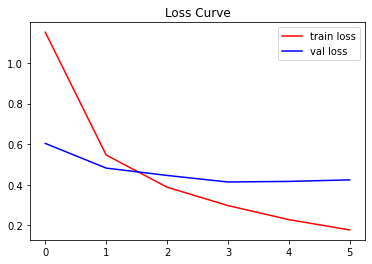

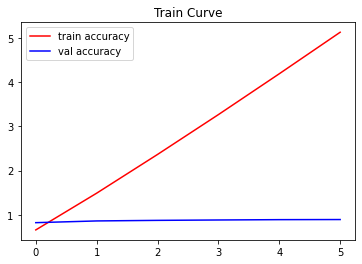

In [ ]:
from sklearn.metrics import f1_score
import numpy as np
import time 
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt



loss_criterion = nn.CrossEntropyLoss()


# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42


np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# ----------------------------
 # Tracking variables 


train_loss_values = []

val_loss_values = []
logits_values =[]

total_train_accuracy = 0
avg_train_accuracy = 0

train_accuracy_values = []
val_accuracy_values = []
predictions=[]
true_labels=[]

#-----------------------------




# Measure the total training time for the whole run.
total_t0 = time.time()
device = torch.device("cuda:0")

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')
    
    #tr and val
    vec_output_tr = []
    vec_output_val =[]

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)


    best_f1 = 0
    model.train()   # It just sets the mode.
                    # tell the model that you are training it. So effectively layers like dropout, batchnorm etc.
                    # which behave differently on the train and test procedures 
                    # know what is going on and hence can behave accordingly.
                    # you can call model.train(mode = False) or model.eval() for testing
                    

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

      # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
        
        # Unpack this training batch from our dataloader. 
        
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids  = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels     = batch[2].to(device)

        # clear previous gradients
        model.zero_grad()        

        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation  
        # PyTorch accumulates the gradients on subsequent backward passes.
        # Else the gradient would point in some other direction than the intended direction towards the minimum
        
        
        # pass a batch of inputs through the model 
        # logits: outputs prior to activation
        logits,vec = model( b_input_ids,    
                            token_type_ids = None, 
                            attention_mask = b_input_mask
                          )
        
        # get model output
        # take output zero because that's the [CLS] token, used for classification
        logits = logits[0]
        
        # calculate loss (batch output, ground truth batch labels)
        loss = loss_criterion(logits, b_labels)
        
        #saving the features_tr
        # Convert Pytorch Tensor to Numpy Array 
        vec = vec.detach().cpu().numpy()
        vec_output_tr.extend(vec)
        
        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        #-------------------------------------------------------

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()

        # Move logits and labels to CPU
        predicted_labels=np.argmax(logits,axis=1)
        predictions.extend(predicted_labels)
        label_ids = b_labels.to('cpu').numpy()
        true_labels.extend(label_ids)

        total_train_accuracy += flat_accuracy(logits, label_ids)


        #-------------------------------------------------------

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()
        
  #----------------------------------------------
    avg_train_accuracy = total_train_accuracy / len(train_dataloader)

    print("")
    print("Training Accuracy: {}".format(avg_train_accuracy))
    train_accuracy_values.append(avg_train_accuracy)
    avg_train_loss = total_train_loss / len(train_dataloader)  
    train_loss_values.append(avg_train_loss) 

#########################################################################
        
      
    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {} ".format(avg_train_loss))
    print("  Training epcoh took: {:} ".format(training_time))
    print("  Learning rate: ", optimizer.param_groups[0]["lr"])
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0
    predictions=[]
    true_labels=[]
    

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            logits,vec = model(b_input_ids, 
                           token_type_ids = None, 
                           attention_mask = b_input_mask
                           )
            
        #new
        logits = logits[0]
        
        #defining the val loss
        loss = loss_criterion(logits, b_labels)
        
        
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()

        # Move logits and labels to CPU
        predicted_labels=np.argmax(logits,axis=1)
        predictions.extend(predicted_labels)
        label_ids = b_labels.to('cpu').numpy()
        true_labels.extend(label_ids)
        
        #saving the features_tr
        vec = vec.detach().cpu().numpy()
        vec_output_val.extend(vec)
        

         ##########################################################################

        logits_values.append(predicted_labels)

        ##########################################################################

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    #--------------------------------
    val_accuracy_values.append(avg_val_accuracy)
    #--------------------------------

    print("  Accuracy: {}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)

    #-----------------------------
    val_loss_values.append(avg_val_loss)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))
    print("Validation F1-Score: {}".format(f1_score(true_labels,predictions,average='macro')))
    curr_f1=f1_score(true_labels,predictions,average='macro')
    if curr_f1 > best_f1:
        best_f1=curr_f1
        torch.save(model.state_dict(), 'FlauBERT_split_title.pt')
        np.save('FlauBERT_best_vec_train_model_train.npy',vec_output_tr)
        np.save('FlauBERT_best_vec_val.npy',vec_output_val)
        
    # Record all statistics from this epoch.
#     training_stats.append(
#         {
#             'epoch': epoch_i + 1,
#             'Training Loss': avg_train_loss,
#             'Valid. Loss': avg_val_loss,
#             'Valid. Accur.': avg_val_accuracy,
#             'Training Time': training_time,
#             'Validation Time': validation_time
#         }
#     )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

print()

plt.plot(np.array(train_loss_values), 'r', label='train loss')
plt.plot(np.array(val_loss_values), 'b', label='val loss'  )
plt.legend()
plt.title('Loss Curve')
plt.show()

print()

plt.plot(np.array(train_accuracy_values), 'r', label='train accuracy')
plt.plot(np.array(val_accuracy_values), 'b', label='val accuracy'  )
plt.legend()
plt.title('Train Curve')
plt.show()






In [ ]:
cp './FlauBERT_split_title.pt' '../drive/My Drive/Rakuten/models/'

In [ ]:
pwd

'/content/Rakuten'

In [ ]:
model_path = '/content/drive/My Drive/Rakuten/models/FlauBERT_split_title.pt'



# Saving and loading the model

torch.load: Uses pickle’s unpickling facilities to deserialize pickled object files to memory.

In [ ]:
# Save model
# try:
#     model_state = {'model': model,
#               'state_dict': model.state_dict(),
#               'optimizer' : optimizer.state_dict()}

#     torch.save(model_state, 'saved_model.pth')
# except:
#     print('Error in saving model')

In [ ]:
device = torch.device("cuda:0")

In [ ]:
checkpoint = torch.load(model_path)
model.load_state_dict(checkpoint) # A state_dict is simply a Python dictionary object 
                                  # that maps each layer to its parameter tensor

<All keys matched successfully>

In [ ]:
import matplotlib.pyplot as plt

def predict_pyt(model, prediction_dataloader):
    """
    model: pytorch model
    prediction_dataloader: DataLoader object for which the predictions has to be made.
    return:
        predictions:    - Direct predicted labels
        softmax_logits: - logits which are normalized with softmax on output"""
    
    # Put model in evaluation mode
    model.eval()

    # Tracking variables 
    predictions = []
    softmax_logits=[]
    vec_outputs = []
    
    true_labels=[]
    val_accuracy_values = []
    total_eval_accuracy = 0
    
    # Predict 
    for batch in (prediction_dataloader):
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        try:
            b_input_ids, b_input_mask, b_labels = batch
        except ValueError:
            b_input_ids, b_input_mask,b_labels, _ = batch

        # Telling the model not to compute or store gradients, saving memory and 
        # speeding up prediction
        with torch.no_grad():

          # Forward pass, calculate logit predictions
            logits,vec = model(b_input_ids, token_type_ids=None, 
                          attention_mask=b_input_mask)
            
            logits = logits[0]

        
        #----- Add softmax---     
        m = nn.Softmax(dim=1)
        
        # # input = torch.randn(2, 3)
        output = m(logits)
        #-------#------
        
        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        predicted_labels=np.argmax(logits,axis=1)
        predictions.extend(predicted_labels)
        softmax_logits.extend(output)

#--------------------------------------------------------

        label_ids = b_labels.to('cpu').numpy()
        true_labels.extend(label_ids)
        total_eval_accuracy += flat_accuracy(logits, label_ids)
#--------------------------------------------------
        
        #vec_outputs saving
        vec = vec.detach().cpu().numpy()
        vec_outputs.extend(vec)

        avg_val_accuracy = total_eval_accuracy / len(prediction_dataloader)

        print ("avg_test_accuracy: {}".format(avg_val_accuracy))
        val_accuracy_values.append(avg_val_accuracy)

    print()

    print(" Final Test Accuracy: {}".format(avg_val_accuracy))
    print()

    plt.plot(np.array(val_accuracy_values), 'r', label='Test accuracy')
    plt.legend()
    plt.title('Test Curve')
    plt.show()

    print()
    print('DONE')
    return predictions, softmax_logits , vec_outputs

def predict_wrapper(model, sentences, max_len=max_len, batch_size = batch_size ):
    """
    Wrapper to create DataLoader object and predict, 
    this is if model and sentences are passed"""
    
    input_ids,attention_masks = prep_input(sentences,labels=None, max_len=max_len)

    prediction_data = data_utils.TensorDataset(input_ids, attention_masks)
    prediction_sampler = SequentialSampler(prediction_data)
    prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

    return predict_pyt(model, prediction_dataloader)

In [ ]:
pwd

'/content/Rakuten'

In [ ]:
# #### Predictions of validation set which is randomly separated from train dataset
start = time.time()
predictions, val_softmax_logits , vec_outputs= predict_pyt(model, test_dataloader)
val_softmax_logits = np.array([ten.detach().cpu().numpy() for ten in val_softmax_logits])
np.save('validation_set_softmax_logits.npy',val_softmax_logits)
print('Time Taken Predict for val set: {:}'.format(format_time(time.time() - start)))

In [ ]:
## Predictions of test dataset 

start = time.time()
predictions, softmax_logits , vec_outputs = predict_wrapper(model, test_sentences)

#saving
np.save('best_vec_test.npy',vec_outputs)
softmax_logits = np.array([ten.detach().cpu().numpy() for ten in softmax_logits])
np.save('X_test_phase1_softmax_logits.npy',softmax_logits)
print('length of predictions {}'.format(len(predictions)))
print('Time Taken Predict for val set: {:}'.format(format_time(time.time() - start) ))

NameError: ignored

In [ ]:
X_test_phase1['prediction_model']= predictions

X_test_phase1['Prdtypecode'] = X_test_phase1['prediction_model'].map(Preprocess.dict_id_to_code)

print(X_test_phase1['Prdtypecode'].value_counts())

X_test_phase1 = X_test_phase1.drop(['prediction_model','Title','Description'],axis=1)

In [ ]:
X_test_phase1.to_csv('y_test_task1_phase1_pred.tsv',sep='\t',index=False)